In [24]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve

In [25]:
# Constants
TEST_SIZE = 0.2
THRESHOLD = 0.4
RANDOM_STATE = 42

**DATA COLLECTION**

In [26]:
# Load the dataset
diabetes_dataset = pd.read_csv('diabetes_prediction_dataset.csv')

In [27]:
# Print the first 5 rows of the dataset
print(diabetes_dataset.head())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [28]:
# Get the number of rows and columns in this dataset
print(diabetes_dataset.shape)

(100000, 9)


In [29]:
# Get the value counts for 'diabetes' (0 - Non-diabetic, 1 - Diabetic) - Raw dataset before any cleaning or preprocessing.
print(diabetes_dataset['diabetes'].value_counts())

diabetes
0    91500
1     8500
Name: count, dtype: int64


**DATA CLEANING**

In [30]:
# Check for missing values
print(diabetes_dataset.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [31]:
# Check for duplicate rows
duplicate_rows = diabetes_dataset.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# Remove duplicate values
diabetes_dataset.drop_duplicates(inplace=True)

# Confirm duplicates have been removed
print(f"Dataset after cleaning: {diabetes_dataset.duplicated().sum()}")

Number of duplicate rows: 3854
Dataset after cleaning: 0


**DATA ENCODING**

In [32]:
# Encode categorical data to numerical values
diabetes_dataset.replace({'gender': {'Female': 0, 'Male': 1, 'Other': 2},
                          'smoking_history': {'never': 0, 'No Info': 1, 'current': 2, 'former': 3, 'ever': 4, 'not current': 5}},
                         inplace=True)

C:\Users\nordi\AppData\Local\Temp\ipykernel_49256\3686324195.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetes_dataset.replace({'gender': {'Female': 0, 'Male': 1, 'Other': 2},


In [33]:
# Print the first 5 rows of the dataset after encoding
print(diabetes_dataset.head())

   gender   age  hypertension  heart_disease  smoking_history    bmi  \
0       0  80.0             0              1                0  25.19   
1       0  54.0             0              0                1  27.32   
2       1  28.0             0              0                0  27.32   
3       0  36.0             0              0                2  23.45   
4       1  76.0             1              1                2  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [34]:
# Separate features and labels
X = diabetes_dataset.drop(columns='diabetes', axis=1)
Y = diabetes_dataset['diabetes']

**DATA STANDARDIZATION**

In [35]:
# Standardize features
scaler = StandardScaler()
scaler.fit(X)
standardized_data = scaler.transform(X)

In [36]:
X = standardized_data
Y = diabetes_dataset['diabetes']

In [37]:
# Convert to DataFrame to view the first few rows
standardized_df = pd.DataFrame(X, columns=diabetes_dataset.drop('diabetes', axis=1).columns)
print(standardized_df.head())

     gender       age  hypertension  heart_disease  smoking_history       bmi  \
0 -0.843459  1.700840     -0.290050       4.848534        -0.896503 -0.314947   
1 -0.843459  0.543372     -0.290050      -0.206248        -0.217828 -0.000216   
2  1.183769 -0.614096     -0.290050      -0.206248        -0.896503 -0.000216   
3 -0.843459 -0.257952     -0.290050      -0.206248         0.460848 -0.572051   
4  1.183769  1.522768      3.447677       4.848534         0.460848 -1.061141   

   HbA1c_level  blood_glucose_level  
0     0.994563             0.043554  
1     0.994563            -1.423096  
2     0.155970             0.483549  
3    -0.496269             0.410216  
4    -0.682623             0.410216  


**TRAIN TEST SPLIT**

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, stratify=Y, random_state=RANDOM_STATE)

In [39]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (76916, 8), Test shape: (19230, 8)


**SMOTE TO BALANCE THE TRAINING DATA**

In [40]:
# Count the number of rows in each class after data cleaning and processing
diabetes_counts = diabetes_dataset['diabetes'].value_counts()
print(diabetes_counts)

diabetes
0    87664
1     8482
Name: count, dtype: int64


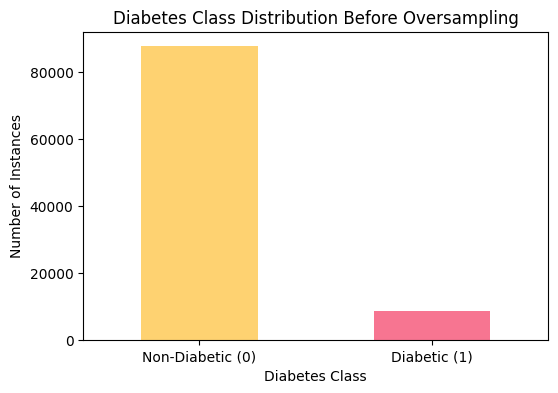

In [41]:
# Plot the bar chart
diabetes_counts.plot(kind='bar', color=['#fed271', '#f77591'], figsize=(6, 4))
plt.title('Diabetes Class Distribution Before Oversampling')
plt.xlabel('Diabetes Class')
plt.ylabel('Number of Instances')
plt.xticks(ticks=[0, 1], labels=['Non-Diabetic (0)', 'Diabetic (1)'], rotation=0)
plt.show()

In [42]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

In [43]:
# After applying SMOTE, resampled training data shape
print(f"X_train_resampled: {X_train_resampled.shape}, Y_train_resampled: {Y_train_resampled.shape}")

X_train_resampled: (140260, 8), Y_train_resampled: (140260,)


In [44]:
# Get the value counts for 'diabetes' (0 - Non-diabetic, 1 - Diabetic) after applying SMOTE
Y_resampled_counts = pd.Series(Y_train_resampled).value_counts()
print(Y_resampled_counts)

diabetes
0    70130
1    70130
Name: count, dtype: int64


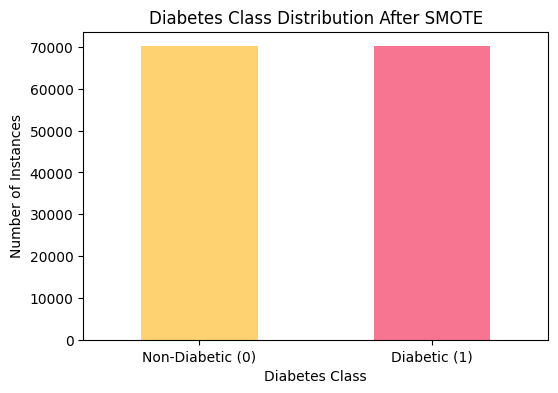

In [45]:
# Plot the bar chart
Y_resampled_counts.plot(kind='bar', color=['#fed271', '#f77591'], figsize=(6, 4))
plt.title('Diabetes Class Distribution After SMOTE')
plt.xlabel('Diabetes Class')
plt.ylabel('Number of Instances')
plt.xticks(ticks=[0, 1], labels=['Non-Diabetic (0)', 'Diabetic (1)'], rotation=0)
plt.show()

**TRAINING THE MODEL**

In [46]:
classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
classifier.fit(X_train_resampled, Y_train_resampled)

c:\Users\nordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

**THRESHOLD TUNING**

In [47]:
# Predict probabilities on the test data
X_test_proba = classifier.predict_proba(X_test)[:, 1] # Get probabilities for class 1 (diabetic)

# Apply threshold tuning
X_test_prediction = (X_test_proba >= THRESHOLD).astype(int)

**MAKING A PREDICTIVE SYSTEM**

In [48]:
#never': 0, 'No Info': 1, 'current': 2, 'former': 3, 'ever': 4, 'not current': 5
input_data = (1, 64.0, 0, 0, 0, 35.06, 5.8, 155)

# Changing the input_data to numpy
input_data_as_numpy_array = np.asarray(input_data)

# Reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

# Standardize the input data
std_data = scaler.transform(input_data_reshaped)
print(std_data)

# Predict probabilities for the new data
prediction_proba = classifier.predict_proba(std_data)[:, 1]

# Apply threshold tuning to make a prediction
prediction = (prediction_proba >= THRESHOLD).astype(int)
print(prediction)

if (prediction[0] == 0):
    print('Prediction: Low Risk (Non-diabetic)')
else:
    print('Prediction: High Risk (Diabetic)')

[[ 1.18376945  0.98855191 -0.29005038 -0.2062479  -0.89650321  1.14345514
   0.2491471   0.41021634]]
[1]
Prediction: High Risk (Diabetic)


c:\Users\nordi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


**MODEL EVALUATION**

In [50]:
# Predict on the test data
X_test_proba = classifier.predict_proba(X_test)[:, 1]
X_test_prediction = (X_test_proba >= THRESHOLD).astype(int)

# Evaluation metrics
accuracy = accuracy_score(Y_test, X_test_prediction)
precision = precision_score(Y_test, X_test_prediction)
recall = recall_score(Y_test, X_test_prediction)
roc_auc = roc_auc_score(Y_test, X_test_proba)
conf_matrix = confusion_matrix(Y_test, X_test_prediction)

# Print the evaluation metrics
print('Accuracy score of the test data: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('ROC-AUC Score:', roc_auc)
print('Confusion Matrix:\n', conf_matrix)

Accuracy score of the test data:  0.9615704628185128
Precision:  0.8085106382978723
Recall:  0.7393867924528302
ROC-AUC Score: 0.974366749183796
Confusion Matrix:
 [[17237   297]
 [  442  1254]]


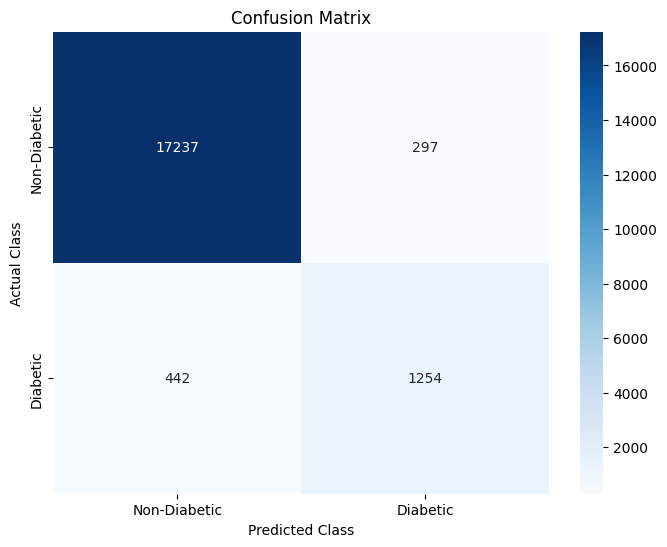

In [51]:
# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()


In [52]:
import pickle

In [53]:
filename_model = 'diabetes_prediction_model.sav'
filename_scaler = 'diabetes_prediction_scaler.sav'
pickle.dump(classifier, open(filename_model, 'wb'))
pickle.dump(scaler, open(filename_scaler, 'wb'))

In [54]:
# Loading the saved model
loaded_model = pickle.load(open('diabetes_prediction_model.sav', 'rb'))
loaded_model = pickle.load(open('diabetes_prediction_scaler.sav', 'rb'))